In [1]:
# pytorch 모델링 패키지

import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torch.nn.functional as F
from torch.utils.data import  Dataset, DataLoader
import torch.optim as optim

torch.__version__

In [ ]:
# 데이터 전처리 및 시각화 패키지
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# 평가지표
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ETC
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
class StockPriceLSTM(nn.Module):
    def __init__(self, config):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate)
        
        self.linear = nn.Linear(in_features=config.hidden_size, out_features=config.output_size)


    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        predictions = self.linear(lstm_out)
        # predictions = self.linear(lstm_out[-1, :])  # 마지막 시퀀스 출력만 사용
        return predictions

In [ ]:
class StockDataset(Dataset):
    def __init__(self, data):
        X = data.drop(columns=['Date','Close']).to_numpy()
        y = data.loc[:, 'Close'].to_numpy()
        
        self.X = torch.Tensor(X).to(device)
        self.y = torch.Tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [ ]:
stock = pd.read_csv('data/AAPL.csv')

In [ ]:
# 20200101 - 20231231 << 1006개 데이터
# 20240101 - 20240131 << 21개 데이터 (예측해야하는 데이터)
split_ = 1006

train_ = stock[:split_]
test_ = stock[split_:]

train_dataset = StockDataset(train_)
test_dataset = StockDataset(test_)

In [ ]:
def fit(model,train_type, dataset, global_config, epochs = 100):

    # optimizer, loss 선언
    optimizer = optim.Adam(model.parameters(), lr=global_config.learning_rate)
    criterion = nn.MSELoss()
    
    
    # dataloader 선언
    dataloader = DataLoader(dataset, 
                            batch_size=global_config.batch_size, 
                            shuffle=False, 
                            num_workers=global_config.num_workers)



    # 학습 상태 및 모델 gpu 선언
    if train_type.lower() in ['train']:

        model.train()
        loss_history = []

        if global_config.verbose:
            t_bar = tqdm(range(epochs), desc = "epoch", leave=global_config.verbose)
        else:
            t_bar = range(epochs)


        for _ in t_bar:
            loss_ = 0
            for featrue, label in dataloader:
                output = model(featrue)

                optimizer.zero_grad()

                loss = criterion(output, label)
                loss_ += loss.item()
                loss.backward()
                optimizer.step()
                
            loss_history.append(loss_/len(dataloader))

        return model, loss_history



    elif train_type.lower() in ['val', 'test', 'predict']:

        model.eval()
        current_input = dataset.X[-1].to(device)
        # print(current_input)
        predictions = []

        for _ in range(global_config.futre_steps):
            with torch.no_grad():
                prediction = model(current_input.unsqueeze(0).unsqueeze(0))
                predictions.append(prediction.item())
                current_input = torch.roll(current_input, -1, 0)
                current_input[-1] = prediction    

        return predictions[1:]


In [ ]:
class Save_checkpoint:
    def __init__(self, score = []):
        self.score = score
    
    def check_score(self, new_score):
        self.score.append(new_score)
        if len(self.score) == 1 or len(self.score) > 1 and max(self.score) == self.score[-1]:
            return True
        else:
            return False
            
    def save_checkpoint(self, model, verbose = True):
        if verbose:
            print(f'Best Model Saved with {max(self.score)}')
            
        torch.save(model.state_dict(), 'best_model.pt')

In [ ]:
def evaluate(y_test, y_pred, graph = True):
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    if graph:
        print("="*30)
        print(" MSE: ", mse)
        print("="*30)
        print("MAPE: ", mape)
        print("="*30)
        plt.plot(range(len(y_test)), y_test, label='Actual')
        plt.plot(range(len(y_test)), y_pred, label='Prediction')
        plt.legend()
        plt.show()

    return mse, mape

In [ ]:
def loss_history_plot(loss_history):
    plt.plot(range(len(loss_history)), loss_history, label='Loss')
    plt.legend()
    plt.show()

In [ ]:
def compare_visualize(data, test_data, y_pred, name):
    plt.plot(data['Date'], data['Close'], label='True')
    plt.plot(test_data['Date'], y_pred, label='pred')
    plt.legend()
    plt.savefig(f'{name}.png')
    plt.show()

In [ ]:
# config 선언
'''
global_config.device
global_config.learning_rate
global_config.batch_size
global_config.num_workers
global_config.epochs
global_config.futre_steps
'''

'''
config.input_size
config.hidden_size
config.lstm_layers
config.dropout_rate
config.output_size
'''

class Config:
    def __init__(self, type, 
                 # model
                 input_size = 8, output_size = 1, hidden_size = 128, lstm_layers = 2, dropout_rate = 0.2, 
                 # global
                 device = device, learning_rate = 0.001, batch_size = 1, num_workers = 0, futre_steps = 22, verbose = True,
                 ):
        
        if type=='model':
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.lstm_layers = lstm_layers
            self.dropout_rate = dropout_rate
            self.output_size = output_size
            

        else:
            # global config
            self.device = device
            self.learning_rate = learning_rate
            self.batch_size = batch_size
            self.num_workers = num_workers
            self.futre_steps = futre_steps
            self.verbose = verbose


In [ ]:
# model_config = Config('model')
# global_config = Config('global')

# # 모델 선언 및 gpu 탑재
# model = StockPriceLSTM_china_ver(model_config)
# model.to(global_config.device)

In [ ]:
# model, loss_h = fit(model, 'train', train_dataset, global_config, 100)
# loss_history_plot(loss_h)
# y_pred = fit(model, 'predict', train_dataset, global_config)
# evaluate(y_test, y_pred)

In [ ]:
# hypterparameter = {'lstm_layers': [1, 2, 3, 4, 5],
#                    'hidden_size': [32, 64, 128, 256, 512],
#                    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
#                 }

# chk = Save_checkpoint()
# global_config = Config('global', verbose=False)

In [ ]:
# # grid hyperparameter search
# score_df = pd.DataFrame(columns=['lstm_layers', 'hidden_size', 'dropout_rate', 'mse', 'mape'])
# df_idx = 0

# for dr in tqdm(hypterparameter['dropout_rate'], desc='dropout_rate', position=0, leave=True):
#     for ll in tqdm(hypterparameter['lstm_layers'], desc='lstm_layers', position=1, leave=False):
#         for hs in tqdm(hypterparameter['hidden_size'], desc='hidden_size', position=2, leave=False):
#             model_config = Config('model', hidden_size=hs, lstm_layers=ll, dropout_rate=dr)
#             model = StockPriceLSTM(model_config).to(global_config.device)

#             model, loss_h = fit(model, 'train', train_dataset, global_config, 100)
            
#             y_pred = fit(model, 'predict', train_dataset, global_config)
#             mse, mae = evaluate(test_dataset.y, y_pred, graph=False)

#             score_df.loc[df_idx] = [ll, hs, dr, mse, mae]
#             df_idx += 1

#             if chk.check_score(mse):
#                 chk.save_checkpoint(model, verbose=False)

In [ ]:
# score_df.to_csv('score_df.csv', index=False)

In [ ]:
score_df = pd.read_csv('score_df.csv')
print(score_df.loc[score_df['mse'].idxmin()])

ll = int(score_df.loc[score_df['mse'].idxmin()].lstm_layers)
hs = int(score_df.loc[score_df['mse'].idxmin()].hidden_size)
dr = float(score_df.loc[score_df['mse'].idxmin()].dropout_rate)

lstm_layers       5.000000
hidden_size     512.000000
dropout_rate      0.100000
mse              25.431347
mape              0.019891
Name: 24, dtype: float64


In [ ]:
global_config = Config('global', verbose=True)
best_model_config = Config('model', hidden_size=256, lstm_layers=2, dropout_rate=0.2)
model = StockPriceLSTM(best_model_config).to(global_config.device)

In [ ]:
model, loss_h = fit(model, 'train', train_dataset, global_config, 500)

epoch:   0%|          | 0/500 [00:00<?, ?it/s]

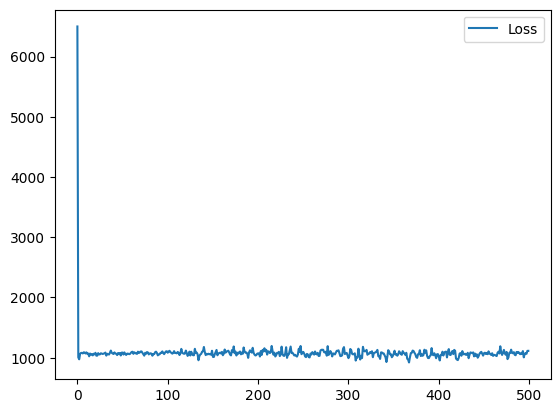

 MSE:  4669.933626984044
MAPE:  0.2826672948455956


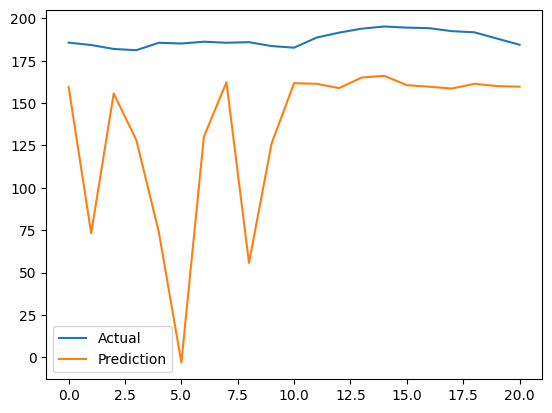

(4669.933626984044, 0.2826672948455956)

In [ ]:
loss_history_plot(loss_h)
y_pred = fit(model, 'predict', train_dataset, global_config)
evaluate(test_dataset.y.tolist(), y_pred)

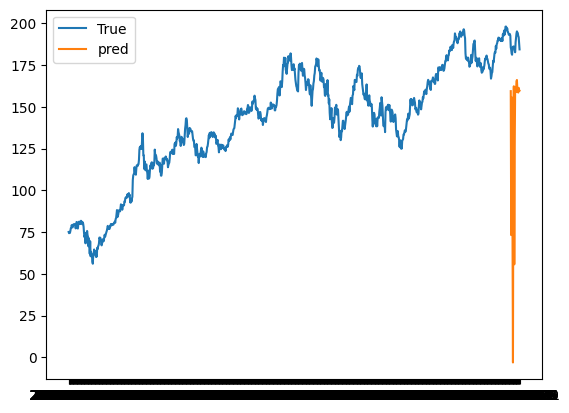

In [ ]:
compare_visualize(stock, test_, y_pred, "LSTM_Stock")